In [1]:
#Remarks
#check coefficients against equations
#be careful of copying and reassign values in numpy array
#export frequencies
#add pot_inf,ex_inf,ey_inf,ez_inf variables and assign s appropriately
#test case case=0 to test set_subdomains

In [1]:
%reset -f
import copy,h5py,os,time
import numpy as np
import numpy.matlib
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import block_diag

#set physicsical constants
echarge=1.602e-19 #elementary charge [C]
perm0=8.85e-12 #vacuum permittivity [F/m]
kA=6.022e23 #Avogadro constant [1/mol]
kB=1.381e-23 #Boltzmann's constant [J/K]

def import_mesh(infile):
    print('Reading group mesh from %s'%infile)
    with h5py.File(infile,'r') as file:
        nodes=np.array(file['mesh/nodes'])
        elements=np.array(file['mesh/elements'])
        faces=np.array(file['mesh/faces'])
        
        in_active_zones=np.array(file['mesh/in_active_zones'])
        with_first_kind_bc=np.array(file['mesh/with_first_kind_bc'])
        with_third_kind_bc=np.array(file['mesh/with_third_kind_bc'])
        
        in_electrolyte=np.array(file['mesh/in_electrolyte'])
        in_solid=np.array(file['mesh/in_solid'])
        in_stern=np.array(file['mesh/in_stern'])
        
        #compute middle point of each element (efficiency to be improved)
        nelem=len(elements[:,0])
        midpoints=np.zeros((nelem,3))
        for i in range(0,nelem):
            for j in range(0,3):
                midpoints[i,j]=.25*sum(nodes[elements[i,:],j])
        
    nind_e=np.unique(elements[in_active_zones].flatten(order='C'))
    print('THE NUMBER OF ACTIVE NODES IS:',len(nind_e))
    print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
    print('THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS:',np.count_nonzero(with_first_kind_bc))
    print('THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS:',np.count_nonzero(with_third_kind_bc))
    print('')
    
    mesh={'elements':elements,'nodes':nodes,'faces':faces,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern,
          'midpoints':midpoints}
    
    return mesh

def import_physics(infile):
    print('Reading group physics from %s'%infile)
    with h5py.File(infile,'r') as file:
        rel_perm_electrolyte=np.array(file['physics/rel_perm_electrolyte'])
        rel_perm_solid=np.array(file['physics/rel_perm_solid'])
        diffusion_electrolyte=np.array(file['physics/diffusion_electrolyte'])
        diffusion_stern=np.array(file['physics/diffusion_stern'])
        mobility_electrolyte=np.array(file['physics/mobility_electrolyte'])
        mobility_stern=np.array(file['physics/mobility_stern'])
        temp_K=np.array(file['physics/temperature'])
        cinf=np.array(file['physics/ion_conc_inf'])
        zval=np.array(file['physics/ion_val'])
        sigma_ss=np.array(file['physics/sigma_ss'])
        
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('SURFACE CHARGE DENSITY FOR STEADY STATE IS:',sigma_ss)
    print('')
    
    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
            'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
            'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
            'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval,
            'sigma_ss':sigma_ss}
    
    return physics

def set_materials(mesh,physics,u,case=1):
    print('Setting materials using predefined cases')
    case=np.maximum(1,int(case))
    case=np.minimum(2,int(case))
    print('TEST CASE IS:',case)
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    rel_perm_electrolyte=physics['rel_perm_electrolyte']
    rel_perm_solid=physics['rel_perm_solid']
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    sigma_ss=physics['sigma_ss']
    
    if case==1:
        c=np.zeros(nelem)
        alpha_x=np.zeros(nelem)
        alpha_y=np.zeros(nelem)
        alpha_z=np.zeros(nelem)

        beta_x=np.zeros(nelem)
        beta_y=np.zeros(nelem)
        beta_z=np.zeros(nelem)

        gamma_x=np.zeros(nelem)
        gamma_y=np.zeros(nelem)
        gamma_z=np.zeros(nelem)
        
        a=np.zeros(nelem)
        f=np.zeros(nelem)
        gs=np.zeros(nface)
        qs=np.zeros(nface)
        snod=np.zeros(nnode)

        c[in_electrolyte]=perm0*rel_perm_electrolyte
        c[in_solid]=perm0*rel_perm_solid
        gs[in_stern]=sigma_ss

        ze=zval*echarge #ion valence times elementary charge
        u_scaled=ze*u/kB/temp_K #scaled potential in elements
        a[:]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u_scaled)
        f[:]=-2*ze*kA*cinf*(np.sinh(u_scaled)-np.cosh(u_scaled)*u_scaled)
        a[in_solid]=0
        f[in_solid]=0
        
    elif case==2:
        c=np.zeros((nelem,3,3))
        alpha_x=np.zeros((nelem,3,3))
        alpha_y=np.zeros((nelem,3,3))
        alpha_z=np.zeros((nelem,3,3))
        
        beta_x=np.zeros((nelem,3,3))
        beta_y=np.zeros((nelem,3,3))
        beta_z=np.zeros((nelem,3,3))
        
        gamma_x=np.zeros((nelem,3,3))
        gamma_y=np.zeros((nelem,3,3))
        gamma_z=np.zeros((nelem,3,3))
        
        a=np.zeros((nelem,3,3))
        f=np.zeros((nelem,3))
        gs=np.zeros((nface,3))
        qs=np.zeros((nface,3,3))
        snod=np.zeros((nelem,3))
        
        c[in_electrolyte,0,0]=perm0*rel_perm_electrolyte
        c[in_electrolyte,1,1]=perm0*rel_perm_electrolyte
        c[in_electrolyte,2,2]=perm0*rel_perm_electrolyte
        
        c[in_solid,0,0]=perm0*rel_perm_solid
        c[in_solid,1,1]=perm0*rel_perm_solid
        c[in_solid,2,2]=perm0*rel_perm_solid
        
        gs[in_stern,0]=sigma_ss
        gs[in_stern,1]=sigma_ss
        gs[in_stern,2]=sigma_ss
        
        ze=zval*echarge #ion valence times elementary charge
        u_scaled=ze*u/kB/temp_K #scaled potential on nodes
        a[:,0,0]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u_scaled)
        a[:,1,1]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u_scaled)
        a[:,2,2]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u_scaled)
        
        f[:,0]=-2*ze*kA*cinf*(np.sinh(u_scaled)-np.cosh(u_scaled)*u_scaled)
        f[:,1]=-2*ze*kA*cinf*(np.sinh(u_scaled)-np.cosh(u_scaled)*u_scaled)
        f[:,2]=-2*ze*kA*cinf*(np.sinh(u_scaled)-np.cosh(u_scaled)*u_scaled)
        
        a[in_solid,:,:]=0
        f[in_solid,:]=0

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    
    return materials

def scale_distance(mesh_in,materials_in,dist_factor):
    print('Scaling distance and related materials')
    print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    mesh=copy.deepcopy(mesh_in)
    materials=copy.deepcopy(materials_in)
    
    mesh['nodes']=mesh['nodes']*dist_factor
    mesh['midpoints']=mesh['midpoints']*dist_factor
    
    materials['alpha_x']=materials['alpha_x']/dist_factor
    materials['alpha_y']=materials['alpha_y']/dist_factor
    materials['alpha_z']=materials['alpha_z']/dist_factor
    
    materials['beta_x']=materials['beta_x']/dist_factor
    materials['beta_y']=materials['beta_y']/dist_factor
    materials['beta_z']=materials['beta_z']/dist_factor
    
    materials['gamma_x']=materials['gamma_x']/dist_factor
    materials['gamma_y']=materials['gamma_y']/dist_factor
    materials['gamma_z']=materials['gamma_z']/dist_factor
    
    materials['a']=materials['a']/dist_factor**2
    materials['f']=materials['f']/dist_factor**2    
    materials['gs']=materials['gs']/dist_factor
    materials['qs']=materials['qs']/dist_factor
    materials['snod']=materials['snod']/dist_factor
    
    return mesh,materials

def compute_gradients(nodes,elements,faces,unod,faceflag=False):
    print('Computing fields and field gradients')
    start=time.time()
    
    if faceflag:
        nface=len(faces)
        u=np.zeros((nface,4),dtype=complex)
        Je=np.ones((3,3))
        for i in range(1): #consider parallelization
            nind=faces[i,:]
            R=rotate_triangle(nodes[nind,:])
            nodes_new=R.dot(nodes[nind,:].T).T
            
            Je[1:,:]=nodes_new[:,:-1].T
            invJe=np.linalg.inv(Je)
            
            xr=sum(nodes_new[:,0])/3
            yr=sum(nodes_new[:,1])/3
            u[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr)*unod[nind])
            
            dudx=sum(unod[nind]*invJe[:,1])
            dudy=sum(unod[nind]*invJe[:,2])
            u[i,1:]=np.linalg.inv(R).dot([dudx,dudy,0])
    else:
        nelem=len(elements)
        u=np.zeros((nelem,4),dtype=complex)
        Je=np.ones((4,4))
        for i in range(nelem): #consider parallelization
            nind=elements[i,:]        
            Je[1:,:]=nodes[nind,:].T
            invJe=np.linalg.inv(Je)

            xr=.25*sum(nodes[nind,0])
            yr=.25*sum(nodes[nind,1])
            zr=.25*sum(nodes[nind,2])
            u[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr+invJe[:,3]*zr)*unod[nind])
            u[i,1]=sum(unod[nind]*invJe[:,1])
            u[i,2]=sum(unod[nind]*invJe[:,2])
            u[i,3]=sum(unod[nind]*invJe[:,3])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return u

def rotate_triangle(nodes):
    A=np.zeros((3,3))
    R=np.zeros((3,3))
    
    xnod=nodes[:,0]
    ynod=nodes[:,1]
    znod=nodes[:,2]
    
    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2
    
    n=n/np.linalg.norm(n)
    z=np.array([0,0,1])
    k=np.cross(n,z)
    k=k/np.linalg.norm(k)
    
    cosb=np.dot(n,z)
    sinb=np.sqrt(1-cosb**2)
    
    A[0,:]=[0,-k[2],k[1]]
    A[1,:]=[k[2],0,-k[0]]
    A[2,:]=[-k[1],k[0],0]
    R=np.eye(3)+A.dot(sinb)+A.dot(A.dot(1-cosb))
    
    return R

def output_unod(nodes,unod,srvfile):
    output=np.genfromtxt(srvfile,skip_header=1)
    rec=output[:,1:4]
    for i in range(len(rec)):
        dist2=(rec[i,0]-nodes[:,0])**2+(rec[i,1]-nodes[:,1])**2+(rec[i,2]-nodes[:,2])**2
        ind=np.argmin(dist2)
        output[i,6]=np.real(unod[ind])
        output[i,7]=np.imag(unod[ind])

    outfile=srvfile+'.out'
    fmt='%d\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e'
    print('Saving results to %s'%outfile)
    np.savetxt(outfile,output,header=str(len(output)),comments='',fmt=fmt)
    print('')
    return output

def build_system(mesh,materials,case=1):
    case=np.maximum(1,int(case))
    case=np.minimum(2,int(case))
    if case==1:
        nnode=len(mesh['nodes'])
        K=csr_matrix((nnode,nnode))
        b=np.zeros(nnode,dtype=complex)
        K,b=assemble_Ke(mesh,materials,K,b,offset=(0,0),nrep=1)
        K,b=set_third_kind_bc(mesh,materials,K,b,offset=(0,0),nrep=1)                
        K,b=set_first_kind_bc(mesh,materials,K,b,offset=(0,0),nrep=1)
    elif case==2:
        nnode=len(mesh['nodes'])
        K=csr_matrix((nnode*3,nnode*3))
        b=np.zeros(nnode*3,dtype=complex)
        K,b=assemble_Ke(mesh,materials,K,b,offset=(0,0),nrep=3)
        K,b=set_third_kind_bc(mesh,materials,K,b,offset=(0,0),nrep=3)                
        K,b=set_first_kind_bc(mesh,materials,K,b,offset=(0,0),nrep=3)

    return K,b

def assemble_Ke(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    
    nodes=mesh['nodes']
    elements=mesh['elements']
    #faces=mesh['faces'] #to be updated with [in_stern]
    nnode=len(mesh['nodes'])
    nelem=len(mesh['elements'])
    #nface=len(mesh['faces']) #to be updated with [in_stern]
    
    cx=np.reshape(materials['cx'],(nelem,nrep,nrep))
    cy=np.reshape(materials['cy'],(nelem,nrep,nrep))
    cz=np.reshape(materials['cz'],(nelem,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'],(nelem,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'],(nelem,nrep,nrep))
    alpha_z=np.reshape(materials['alpha_z'],(nelem,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'],(nelem,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'],(nelem,nrep,nrep))
    beta_z=np.reshape(materials['beta_z'],(nelem,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'],(nelem,nrep,nrep))
    gamma_y=np.reshape(materials['gamma_y'],(nelem,nrep,nrep))
    gamma_z=np.reshape(materials['gamma_z'],(nelem,nrep,nrep))
    a=np.reshape(materials['a'],(nelem,nrep,nrep))
    f=np.reshape(materials['f'],(nelem,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nelem*16*nrep**2,dtype=int)
    J=np.zeros(cnt+nelem*16*nrep**2,dtype=int)
    V=np.zeros(cnt+nelem*16*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(4*nrep),4*nrep,1).T
    COL=np.matlib.repmat(np.arange(4*nrep),4*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nelem):
        nind=elements[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ke,be=build_Ke(xnod,ynod,znod,cx=cx[i],cy=cy[i],cz=cz[i],
                       alpha_x=alpha_x[i],alpha_y=alpha_y[i],alpha_z=alpha_z[i],
                       beta_x=beta_x[i],beta_y=beta_y[i],beta_z=beta_z[i],
                       gamma_x=gamma_x[i],gamma_y=gamma_y[i],gamma_z=gamma_z[i],
                       a=a[i],f=f[i],nrep=nrep)
        nind_rep=REP[nind].flatten(order='C')
        I[cnt:cnt+16*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+16*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+16*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+16*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def set_third_kind_bc(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the boundary condition of the third kind')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc']
    
    nodes=mesh['nodes']
    faces_on_bc=mesh['faces'][with_third_kind_bc]
    nnode=len(nodes)
    nface_on_bc=len(faces_on_bc)
    
    gs=np.reshape(materials['gs'][with_third_kind_bc],(nface_on_bc,nrep))
    qs=np.reshape(materials['qs'][with_third_kind_bc],(nface_on_bc,nrep,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_on_bc*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_on_bc*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_on_bc*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nface_on_bc):
        nind=faces_on_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ks,bs=build_Ks(xnod,ynod,znod,gs=gs[i],qs=qs[i],nrep=nrep)
        nind_rep=REP[nind].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+9*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def set_first_kind_bc(mesh,materials,K_in,b_in,offset=(0,0),nrep=1): #continue from here 11/8
    print('Incoorprating the Dirichlet boundary condition')
    start=time.time()
    with_first_kind_bc=mesh['with_first_kind_bc']
    
    nodes=mesh['nodes']
    nodes_on_bc=mesh['nodes'][with_first_kind_bc]
    nnode=len(nodes)
    nnode_on_bc=len(nodes_on_bc)
    snod=np.reshape(materials['snod'][with_first_kind_bc],(nnode_on_bc,nrep))
    
    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_on_bc=np.where(with_first_kind_bc)[0]
    nind_inside=np.where(~with_first_kind_bc)[0]
    
    for i in nind_inside:
        rows=REP[i].flatten(order='C')+offset[0]
        cols=REP[nind_on_bc].flatten(order='C')+offset[1]
        for irow in np.asmatrix(rows).T:
            b[irow]=b[irow]-K[irow,cols].dot(snod.flatten(order='C'))
    
    rows=REP[nind_on_bc].flatten(order='C')+offset[0]
    cols=REP[nind_on_bc].flatten(order='C')+offset[1]    
    K=zero_rows(K,rows)
    K=zero_cols(K,cols)
    b[rows]=snod.flatten(order='C')
    diag=csr_matrix(K.shape).tolil()
    diag[rows,cols]=1
    K=K+diag
    
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def set_subdomains(mesh_in,materials_in):
    print('Re-indexing elements and faces for subdomains')
    mesh=copy.deepcopy(mesh_in)
    materials=copy.deepcopy(materials_in)
    
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    in_active_zones=mesh['in_active_zones']
    with_first_kind_bc=mesh['with_first_kind_bc']
    with_third_kind_bc=mesh['with_third_kind_bc']
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    midpoints=mesh['midpoints']
    
    nind=np.unique(elements[in_active_zones].flatten(order='C'))
    nind_global_to_local=-np.ones(len(nodes),dtype=int)
    nind_global_to_local[nind]=np.arange(len(nind)) #value of -1 is out of comput. domain
    fmask=((faces[:,0]!=-1)&(faces[:,1]!=-1))&(faces[:,2]!=-1) #value of False is out of comput. domain
    
    mesh['nodes']=nodes[nind,:]
    mesh['elements']=nind_global_to_local[elements[in_active_zones,:]]
    mesh['faces']=nind_global_to_local[faces[fmask,:]]
    mesh['midpoints']=midpoints[nind,:]
    
    mesh['in_active_zones']=np.ones(len(elements),dtype=bool)
    mesh['with_first_kind_bc']=with_first_kind_bc[nind]
    mesh['with_third_kind_bc']=with_third_kind_bc[fmask]
    
    mesh['in_solid']=in_solid[in_active_zones]
    mesh['in_electrolyte']=in_electrolyte[in_active_zones]
    mesh['in_stern']=in_stern[fmask]
    
    #print('THE NUMBER OF NODES BEFORE RE-INDEXING IS:',len(mesh_in['nodes']))
    #print('THE NUMBER OF ELEMENTS BEFORE RE-INDEXING IS:',len(mesh_in['elements']))
    #print('THE NUMBER OF FACES BEFORE RE-INDEXING IS:',len(mesh_in['faces']))
    print('THE NUMBER OF NODES AFTER RE-INDEXING IS:',len(mesh['nodes']))
    print('THE NUMBER OF ELEMENTS AFTER RE-INDEXING IS:',len(mesh['elements']))
    print('THE NUMBER OF FACES AFTER RE-INDEXING IS:',len(mesh['faces']))
    print('')
    
    materials['cx']=materials['cx'][in_active_zones]
    materials['cy']=materials['cy'][in_active_zones]
    materials['cz']=materials['cz'][in_active_zones]
    materials['alpha_x']=materials['alpha_x'][in_active_zones]
    materials['alpha_y']=materials['alpha_y'][in_active_zones]
    materials['alpha_z']=materials['alpha_z'][in_active_zones]
    materials['beta_x']=materials['beta_x'][in_active_zones]
    materials['beta_y']=materials['beta_y'][in_active_zones]
    materials['beta_z']=materials['beta_z'][in_active_zones]
    materials['gamma_x']=materials['gamma_x'][in_active_zones]
    materials['gamma_y']=materials['gamma_y'][in_active_zones]
    materials['gamma_z']=materials['gamma_z'][in_active_zones]
    
    materials['a']=materials['a'][in_active_zones]
    materials['f']=materials['f'][in_active_zones]    
    materials['gs']=materials['gs'][fmask]
    materials['qs']=materials['qs'][fmask]
    materials['snod']=materials['snod'][nind]
    
    return mesh,materials

def build_Ke(xnod,ynod,znod,cx,cy,cz,alpha_x,alpha_y,alpha_z,beta_x,
             beta_y,beta_z,gamma_x,gamma_y,gamma_z,a,f,nrep=1):
    Ke=np.zeros((4*nrep,4*nrep),dtype=complex)
    be=np.zeros(4*nrep,dtype=complex)
    Je=np.ones((4,4))
    Je[1,:]=xnod
    Je[2,:]=ynod
    Je[3,:]=znod
    invJe=np.linalg.inv(Je)
    vol=np.linalg.det(Je)/6
    
    for i in range(4*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3,4
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(4*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3,4
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     cz[kk,ll]*invJe[ii,3]*invJe[jj,3]+a[kk,ll]*(1+delta)/20+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2]+alpha_z[kk,ll]*invJe[ii,3])/4+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2]+beta_z[kk,ll]*invJe[jj,3])/4)*vol
        be[i]=(gamma_x[kk,ll]*invJe[ii,1]+gamma_y[kk,ll]*invJe[ii,2]+
               gamma_z[kk,ll]*invJe[ii,3]+f[kk]/4)*vol
    
    return Ke,be

def build_Ks(xnod,ynod,znod,gs,qs,nrep=1):
    Ks=np.zeros((3*nrep,3*nrep),dtype=complex)
    bs=np.zeros(3*nrep,dtype=complex)
    
    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2
    
    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ks[i,j]=qs[kk,ll]*area*(1+delta)/12
        bs[i]=gs[kk]*area/3
    
    return Ks,bs

def zero_rows(M,rows):
    diag=sparse.eye(M.shape[0]).tolil()
    for r in rows:
        diag[r,r]=0
    
    return diag.dot(M)

def zero_cols(M,cols):
    diag=sparse.eye(M.shape[0]).tolil()
    for c in cols:
        diag[c,c]=0
    
    return M.dot(diag)
    
def solve_unod(K,b):
    print('Calling sparse linear system solver')
    start=time.time()
    K.eliminate_zeros()
    unod=spsolve(K,b)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    
    return unod

def an_sol(r,a,rel_perm,temp_K,cinf,zval,zeta,gradflag=0):
    print('Computing 1D LPB solution for sphere')
    perm=perm0*rel_perm
    ze=zval*echarge
    debye_len=np.sqrt(perm*kB*temp_K/2/ze**2/kA/cinf)
    print('SOLID PARTICLE RADIUS IS:',a)
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    if gradflag:
        print('SURFACE CHARGE DENSITY AT SPHERE IS:',zeta)
    else:
        print('POTENTIAL AT SPHERE IS:',zeta)
    print('DEBYE LENGTH IS:',debye_len*1e9,'nm')
    print('')
    
    if gradflag:
        zeta=zeta/(1/debye_len+1/a)/perm0/rel_perm
    
    dist=np.sqrt(r[:,0]**2+r[:,1]**2+r[:,2]**2)
    u=np.zeros((len(dist),4))
    mask=dist>=a
    u[mask,0]=zeta*a*np.exp((a-dist[mask])/debye_len)/dist[mask]
    u[~mask,0]=zeta
    u[mask,1]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,0]/dist[mask]
    u[mask,2]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,1]/dist[mask]
    u[mask,3]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,2]/dist[mask]
    return u

if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9
    case=2
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    materials=set_materials(mesh,physics,u=0,case=case)
    mesh_scaled,materials_scaled=scale_distance(mesh,materials,dist_factor)
    mesh_subset,materials_subset=set_subdomains(mesh_scaled,materials_scaled)
    K,b=build_system(mesh_subset,materials_subset,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    in_active_zones=mesh['in_active_zones']
    nind=np.unique(elements[in_active_zones,:].flatten(order='C'))
    unod=np.zeros((len(nodes),int(len(b)/len(nind))),dtype=complex)
    
    #unod=solve_unod(K/perm0,b/perm0)
    unod[nind,:]=np.reshape(solve_unod(K,b),(len(nind),unod.shape[1]))
    
    output=output_unod(nodes,unod[:,0],srvfile)
    ansol=an_sol(output[:,1:5],a=5e-9,rel_perm=78.5,temp_K=298,
                 cinf=100,zval=1,zeta=0.01,gradflag=1)
    #u=compute_gradients(nodes,elements,faces,unod,faceflag=True)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR STEADY STATE IS: 0.01

Setting materials using predefined cases
TEST CASE IS: 2

Scaling distance and related materials
DISTANCE SCALING FACTOR IS: 1.00e+09

Re-indexing elements and faces for subdomains
THE NUMBER OF NODES AFTER RE-INDEXING IS: 24157
THE NUMBER OF ELEMENTS AFTER RE-INDEXING IS: 135851
THE NUMBER OF FACES AFTER RE-INDEXING IS: 17578

Asse

Computing 1D LPB solution for sphere
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm



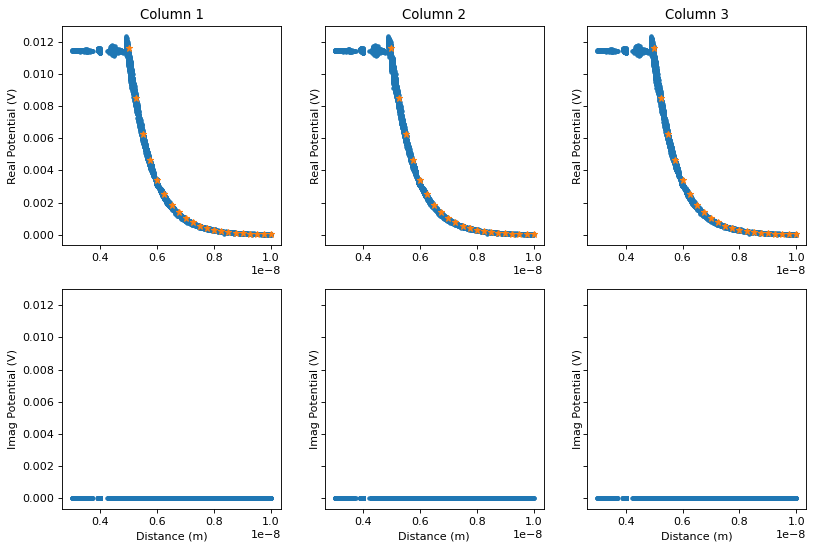

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

ansol=an_sol(output[:,1:5],a=5e-9,rel_perm=78.5,temp_K=298,
             cinf=100,zval=1,zeta=0.01,gradflag=1)

fig,ax=plt.subplots(2,3,sharey=True,figsize=(12,8),dpi=80)
axs=ax.flatten()

dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
mask=(dist>3e-9)&(dist<1e-8)
for i in range(unod.shape[1]):
    axs[i].plot(dist[mask],np.real(unod[mask,i]),'.')
    axs[i].plot(output[:,1],ansol[:,0],'*')
    axs[i].set_title('Column %d'%(i+1))
    axs[i].set_ylabel('Real Potential (V)')
    
    axs[i+3].plot(dist[mask],np.imag(unod[mask,i]),'.')
    axs[i+3].set_xlabel('Distance (m)')
    axs[i+3].set_ylabel('Imag Potential (V)')

#     mask=dist<=5e-9
#     axs[2].plot(dist[mask],np.real(unod[mask,0]),'.')

Computing fields and field gradients
Time elapsed  4.340797662734985 sec

Computing 1D LPB solution for sphere
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm



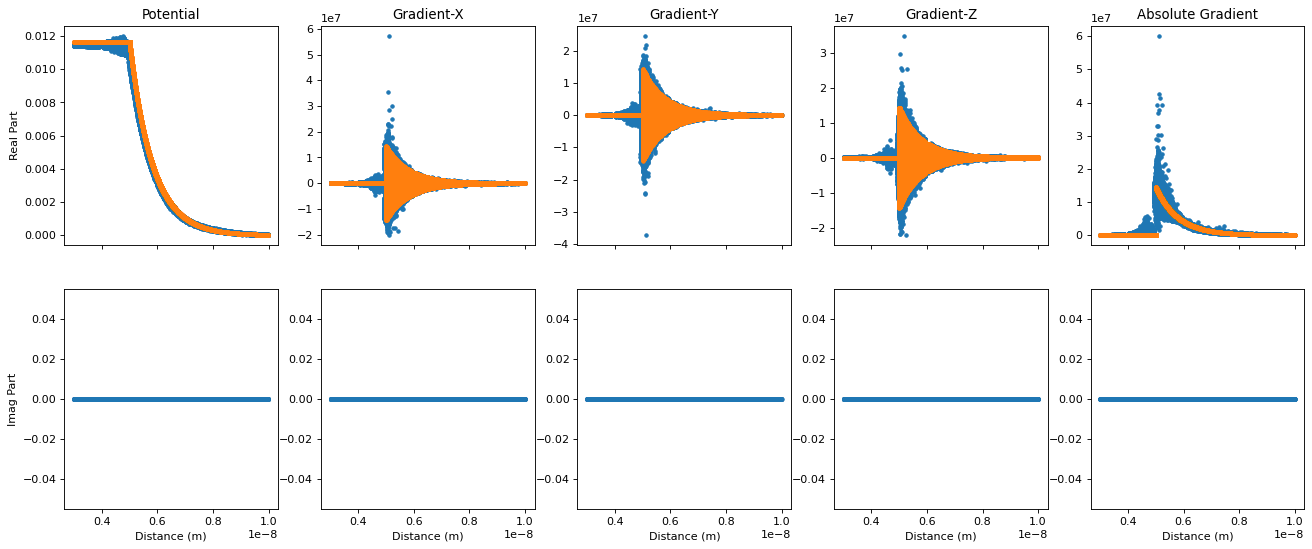

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

midpoints=mesh['midpoints']
dist=np.sqrt(midpoints[:,0]**2+midpoints[:,1]**2+midpoints[:,2]**2)
u=compute_gradients(nodes,elements,faces,unod[:,0],faceflag=False)
ansol=an_sol(midpoints,a=5e-9,rel_perm=78.5,temp_K=298,
             cinf=100,zval=1,zeta=0.01,gradflag=1)
u=np.append(u,np.asmatrix(np.sqrt(u[:,1]**2+u[:,2]**2+u[:,3]**2)).T,axis=1)
ansol=np.append(ansol,np.asmatrix(np.sqrt(ansol[:,1]**2+ansol[:,2]**2+ansol[:,3]**2)).T,axis=1)

fig,ax=plt.subplots(2,5,sharex=True,figsize=(20,8),dpi=80)
axs=ax.flatten()
titles=['Potential','Gradient-X','Gradient-Y','Gradient-Z','Absolute Gradient']

mask=(dist>3e-9)&(dist<1e-8)
for i in range(u.shape[1]):
    axs[i].plot(dist[mask],np.real(u[mask,i]),'.')
    axs[i].plot(dist[mask],ansol[mask,i],'.')
    axs[i].set_title(titles[i])
    
    axs[i+5].plot(dist[mask],np.imag(u[mask,i]),'.')
    axs[i+5].set_xlabel('Distance (m)')
    
axs[0].set_ylabel('Real Part')
axs[5].set_ylabel('Imag Part')
plt.show()